In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
def parse_dat_file_to_dataframe(file_path):
    # List to store event data (each event is a dict)
    events_data = []
    current_event = {}
    event_number = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing spaces
            
            # Detect the start of a new event
            event_match = re.match(r'% Event (\d+)', line)
            if event_match:
                # If we are in the middle of an event, store it before moving to the next one
                if current_event:
                    events_data.append(current_event)
                    current_event = {}
                
                # Start a new event
                event_number = int(event_match.group(1))
                current_event['Event'] = event_number
            
            # Split the key-value pairs and store them in the current_event dict
            elif line and not line.startswith('%'):
                key_value = line.split('\t')
                if len(key_value) == 2:
                    key, value = key_value
                    current_event[key] = float(value) if value.replace('.', '', 1).isdigit() else value

        # Append the last event after reading the file
        if current_event:
            events_data.append(current_event)
    
    # Convert list of event dictionaries to a DataFrame
    df = pd.DataFrame(events_data)
    
    return df

In [69]:
folder = "O:/Nat_ASVAP/OMLAB_DATA/ASVAP_press_"
month = "Oct2024/"
run = "Run-003"

start_file = 1
path_intial = folder+month+run+"/"+run+f"-00{start_file}.dat"
path = folder+month+run
num_files = 57


In [70]:
df = parse_dat_file_to_dataframe(path_intial)
for i in range(start_file+1,num_files+1):
    
    if i <10:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-00{i}.dat")
    elif 10 <= i <100:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-0{i}.dat")
    elif 100 <= i:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-{i}.dat")
    df = pd.concat([df,next_file],ignore_index=True)
zero_indices = df.index[df['Some_calibration'] == 0.0].tolist()
df = df.drop(index=zero_indices).reset_index(drop=True)

In [71]:
def linfunc(x, a, b):
    return x*a + b

def expfunc(x, a, b ,c):
    return a* np.exp(b * x ) + c

def lnfunc(x,a,b,c):
    return  a*np.log(b*x) + c

intial_guess = [-10,-4,-35]

data_start, data_stop =20,-1

func = expfunc

xdata = ((df["Time_ms"]-df["Time_ms"][0])*2.7778*10**(-7)) #Time in hours
# ydata = df["TC_CH8_TransCh_C"]#.astype(float) * 10**(-7) #convert to 1e-7 mbar
ydata = df["TC_CH1_Samp_C"].astype(float)
popt, pcov = curve_fit(func, xdata[data_start:data_stop],ydata[data_start:data_stop], p0=intial_guess, maxfev=10000 )
print(popt, np.diag(pcov))

[-36.76494793  -4.16184108  34.10656673] [5.96648446e-04 2.44729702e-05 4.73753039e-05]


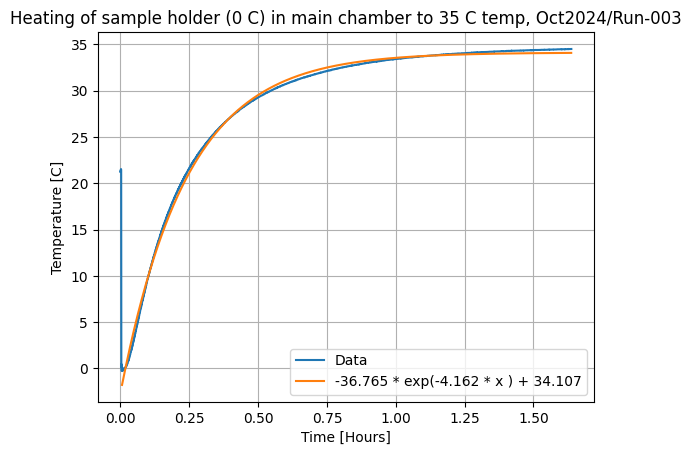

In [75]:
plt.plot(xdata,ydata, label="Data")
if func == expfunc:
    plt.plot(xdata[data_start:data_stop], expfunc(xdata[data_start:data_stop],*popt), label="{:.3f} * exp({:.3f} * x ) + {:.3f}".format(*popt))
elif func == linfunc:
    plt.plot(xdata, linfunc(xdata,*popt), label="{:.7f}*x + {:.7f}".format(*popt))
elif func == lnfunc:
    plt.plot(xdata[data_start:data_stop], lnfunc(xdata[data_start:data_stop], *popt), label="{} * ln({} * x) + {}".format(*popt))
plt.xlabel("Time [Hours]")
plt.ylabel("Temperature [C]")
plt.grid()
plt.legend()
# plt.xscale("log")
plt.title("Heating of sample holder (0 C) in main chamber to 35 C temp, {}".format(month+run))
# plt.savefig("Plots/heating of sample holder to 35 C Oct run 3")

34.03507809557894


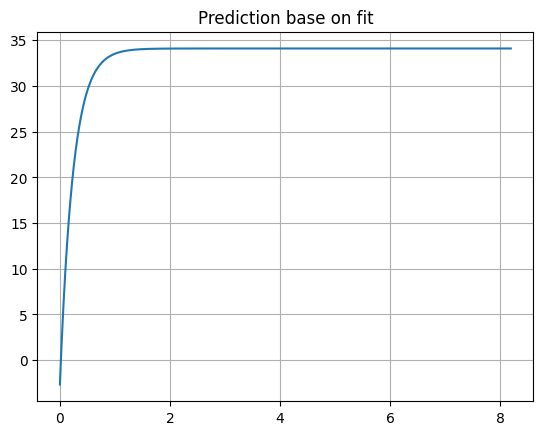

In [73]:
x = np.linspace(0,xdata.tolist()[-1]*5, 10000)
plt.plot(x, expfunc(x, *popt))
plt.title("Prediction base on fit")
plt.grid()
print(expfunc(1.5, *popt) )

In [74]:
df

,Some_calibration,Event,DAQ_TimeStamp_UTC,Time_ms,PT_1_Chvalve_C,PT_2_Chtop_C,PT_3_free_C,PT_4_Chbot_C,TC_int,TC_CH1_Samp_C,...,G4_Not_Connected_value_1e7mbar,G4_Not_Connected_status,G5_Main_Barocel_value_1e7mbar,G5_Main_Barocel_status,G6_Main_Inficone_value_1e7mbar,G6_Main_Inficone_status,Valve_pre_chamber,Valve_turbo_main_chamber,Valve_ion_main_chamber,Valve_aux
0,NaN,1.0,03-10-2024 14:14:36,861004859.0,38.412,34.374,20.524,34.988,21.198769,21.220339,...,0.0,0.0,660.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
1,NaN,2.0,03-10-2024 14:14:37,861006371.0,38.412,34.374,20.518,34.989,21.198769,21.220339,...,0.0,0.0,660.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
2,NaN,3.0,03-10-2024 14:14:38,861007062.0,38.396,34.374,20.518,34.989,21.198627,21.409521,...,0.0,0.0,660.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
3,NaN,4.0,03-10-2024 14:14:40,861008567.0,38.396,34.373,20.527,34.989,21.198627,21.409521,...,0.0,0.0,730.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
4,NaN,5.0,03-10-2024 14:14:40,861009269.0,38.396,34.373,20.527,34.991,21.198627,21.379826,...,0.0,0.0,630.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,NaN,5696.0,03-10-2024 15:52:46,866894517.0,38.348,34.413,20.294,35.071,21.246141,34.483135,...,0.0,0.0,640.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
5696,NaN,5697.0,03-10-2024 15:52:47,866896123.0,38.348,34.422,20.294,35.071,21.246141,34.483135,...,0.0,0.0,640.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
5697,NaN,5698.0,03-10-2024 15:52:49,866897623.0,38.348,34.422,20.290,35.066,21.246000,34.486679,...,0.0,0.0,570.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
5698,NaN,5699.0,03-10-2024 15:52:49,866898227.0,38.345,34.422,20.290,35.066,21.246141,34.486816,...,0.0,0.0,680.0,11.0,38838000.0,11.0,1.0,0.0,0.0,0.0
